In [1]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torch.fft as fft
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [2]:
# Define dataset path
dataset_path = "E:/CP Dataset/cwt"  # Change to your actual path

# Define image size (for ResNet-18 input)
IMG_SIZE = 224

# Define categories (classes)
categories = ["Impeller (3.0BAR)", "Mechanical seal Hole (3BAR)", "Mechanical seal Scratch (3.0BAR)", "Normal (3BAR)"]
class_labels = {category: i for i, category in enumerate(categories)}  # Map class names to labels

# Print class labels
print("Class Labels Mapping:", class_labels)


Class Labels Mapping: {'Impeller (3.0BAR)': 0, 'Mechanical seal Hole (3BAR)': 1, 'Mechanical seal Scratch (3.0BAR)': 2, 'Normal (3BAR)': 3}


In [3]:
# Lists to store image paths and labels
image_paths = []
labels = []

# Loop through each category folder and load images
for category in categories:
    folder_path = os.path.join(dataset_path, category)
    for file in os.listdir(folder_path):
        if file.endswith(".png"):  # Ensure only images are loaded
            image_paths.append(os.path.join(folder_path, file))
            labels.append(class_labels[category])

# Print dataset statistics
print(f"Total Images Loaded: {len(image_paths)}")
print(f"Example Image Path: {image_paths[0]}")
print(f"Corresponding Label: {labels[0]}")


Total Images Loaded: 1247
Example Image Path: E:/CP Dataset/cwt\Impeller (3.0BAR)\0.png
Corresponding Label: 0


In [4]:
# Split dataset into train (70%) and test (30%)
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.3, stratify=labels, random_state=42
)

# Print dataset sizes
print(f"Training Images: {len(train_paths)}")
print(f"Testing Images: {len(test_paths)}")


Training Images: 872
Testing Images: 375


In [5]:
# Define image transformations for training (including data augmentation)
transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Resize to match ResNet-18 input
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images
    transforms.RandomRotation(15),  # Random rotation for generalization
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize images
])

# Define image transformations for testing (no augmentation)
transform_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),  # Resize to match ResNet-18 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize images
])

print("Image transformations defined successfully!")


Image transformations defined successfully!


In [6]:
class CWDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)  # Load grayscale image
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert to RGB format
        
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)

        return img, label

# Print success message
print("Custom Dataset Class Created Successfully!")


Custom Dataset Class Created Successfully!


In [7]:
# Define batch size
batch_size = 32

# Create datasets
train_dataset = CWDataset(train_paths, train_labels, transform=transform_train)
test_dataset = CWDataset(test_paths, test_labels, transform=transform_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Print success message
print(f"Training Batches: {len(train_loader)} | Testing Batches: {len(test_loader)}")


Training Batches: 28 | Testing Batches: 12


In [8]:
class SCAM(nn.Module):
    def __init__(self, in_channels):
        super(SCAM, self).__init__()

        # Channel Attention
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)
        self.global_max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // 16)
        self.fc2 = nn.Linear(in_channels // 16, in_channels)
        self.sigmoid = nn.Sigmoid()

        # Spatial Attention
        self.conv1 = nn.Conv2d(2, 1, kernel_size=7, padding=3)
    
    def forward(self, x):
        batch, channels, _, _ = x.size()

        # Channel Attention
        avg_out = self.global_avg_pool(x).view(batch, channels)
        max_out = self.global_max_pool(x).view(batch, channels)
        avg_out = F.relu(self.fc1(avg_out))
        max_out = F.relu(self.fc1(max_out))
        channel_weight = self.sigmoid(self.fc2(avg_out + max_out)).view(batch, channels, 1, 1)
        x = x * channel_weight

        # Spatial Attention
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        spatial_weight = self.sigmoid(self.conv1(torch.cat([avg_out, max_out], dim=1)))
        x = x * spatial_weight

        return x

# Print success message
print("SCAM (Spatial & Channel Attention Module) implemented successfully!")


SCAM (Spatial & Channel Attention Module) implemented successfully!


In [9]:
class FFTFeatureExtractor(nn.Module):
    def __init__(self):
        super(FFTFeatureExtractor, self).__init__()

    def forward(self, x):
        # Convert spatial image features to frequency domain
        fft_features = torch.fft.fft2(x)  # Compute 2D FFT
        fft_features = torch.abs(fft_features)  # Get magnitude spectrum
        fft_features = torch.log1p(fft_features)  # Apply log transform to enhance visualization
        
        return fft_features

# Print success message
print("FFT Feature Enhancement implemented successfully!")


FFT Feature Enhancement implemented successfully!


In [10]:
class EnhancedResNet18(nn.Module):
    def __init__(self, num_classes=4):
        super(EnhancedResNet18, self).__init__()

        # Load Pretrained ResNet-18 Model
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

        # Modify the first layer to accept 6 channels (RGB + FFT)
        self.model.conv1 = nn.Conv2d(6, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Integrate Attention & FFT Modules
        self.scam1 = SCAM(64)  # Attention after first layer
        self.fft_module = FFTFeatureExtractor()  # FFT before passing to ResNet

        # Modify Fully Connected Layer for 4-class classification
        self.model.fc = nn.Linear(512, num_classes)

        # Dropout for better generalization
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # Extract frequency features using FFT
        fft_features = self.fft_module(x)

        # Concatenate spatial and frequency domain features (6 channels)
        x = torch.cat([x, fft_features], dim=1)

        # Pass through ResNet first layer
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)

        # Apply Attention after first convolutional block
        x = self.scam1(x)

        # Pass through the rest of ResNet-18 layers
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)

        # Global Average Pooling
        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)

        # Fully Connected Layer with Dropout
        x = self.dropout(x)
        x = self.model.fc(x)

        return x

# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EnhancedResNet18(num_classes=4).to(device)

# Print model summary
print(model)


EnhancedResNet18(
  (model): ResNet(
    (conv1): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [11]:
# Define Loss Function (Cross Entropy for Classification)
criterion = nn.CrossEntropyLoss()

# Define Optimizer (Adam with L2 Regularization)
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-3)

# Print success message
print("Loss function and optimizer initialized successfully!")


Loss function and optimizer initialized successfully!


In [14]:
# Training Loop
import torch.nn.functional as F  # Fix missing F import

def train(model, train_loader, criterion, optimizer, epochs=10):
    model.train()  # Set model to training mode
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}, Accuracy: {train_acc:.2f}%")

# Start Training
train(model, train_loader, criterion, optimizer, epochs=30)


100%|██████████| 28/28 [00:30<00:00,  1.10s/it]


Epoch [1/30], Loss: 24.2642, Accuracy: 59.06%


100%|██████████| 28/28 [00:24<00:00,  1.14it/s]


Epoch [2/30], Loss: 12.5304, Accuracy: 76.15%


100%|██████████| 28/28 [00:24<00:00,  1.14it/s]


Epoch [3/30], Loss: 11.3707, Accuracy: 79.70%


100%|██████████| 28/28 [00:32<00:00,  1.16s/it]


Epoch [4/30], Loss: 10.6456, Accuracy: 80.73%


100%|██████████| 28/28 [00:24<00:00,  1.14it/s]


Epoch [5/30], Loss: 8.2484, Accuracy: 86.12%


100%|██████████| 28/28 [00:24<00:00,  1.13it/s]


Epoch [6/30], Loss: 8.8379, Accuracy: 84.98%


100%|██████████| 28/28 [00:24<00:00,  1.14it/s]


Epoch [7/30], Loss: 9.4515, Accuracy: 82.80%


100%|██████████| 28/28 [00:24<00:00,  1.13it/s]


Epoch [8/30], Loss: 8.3780, Accuracy: 89.79%


100%|██████████| 28/28 [00:26<00:00,  1.04it/s]


Epoch [9/30], Loss: 7.1518, Accuracy: 88.88%


100%|██████████| 28/28 [00:34<00:00,  1.24s/it]


Epoch [10/30], Loss: 5.9650, Accuracy: 90.71%


100%|██████████| 28/28 [00:24<00:00,  1.13it/s]


Epoch [11/30], Loss: 5.0963, Accuracy: 92.55%


100%|██████████| 28/28 [00:24<00:00,  1.14it/s]


Epoch [12/30], Loss: 4.6055, Accuracy: 93.35%


100%|██████████| 28/28 [00:24<00:00,  1.14it/s]


Epoch [13/30], Loss: 8.6511, Accuracy: 88.19%


100%|██████████| 28/28 [00:24<00:00,  1.13it/s]


Epoch [14/30], Loss: 6.8292, Accuracy: 89.22%


100%|██████████| 28/28 [00:24<00:00,  1.14it/s]


Epoch [15/30], Loss: 5.1814, Accuracy: 90.71%


100%|██████████| 28/28 [00:24<00:00,  1.13it/s]


Epoch [16/30], Loss: 4.5507, Accuracy: 92.55%


100%|██████████| 28/28 [00:24<00:00,  1.13it/s]


Epoch [17/30], Loss: 5.0822, Accuracy: 92.78%


100%|██████████| 28/28 [00:24<00:00,  1.13it/s]


Epoch [18/30], Loss: 5.1928, Accuracy: 91.74%


100%|██████████| 28/28 [00:24<00:00,  1.13it/s]


Epoch [19/30], Loss: 5.1425, Accuracy: 92.20%


100%|██████████| 28/28 [00:24<00:00,  1.14it/s]


Epoch [20/30], Loss: 5.1504, Accuracy: 92.32%


100%|██████████| 28/28 [00:24<00:00,  1.14it/s]


Epoch [21/30], Loss: 4.7241, Accuracy: 93.00%


100%|██████████| 28/28 [00:24<00:00,  1.14it/s]


Epoch [22/30], Loss: 4.0276, Accuracy: 94.04%


100%|██████████| 28/28 [00:24<00:00,  1.14it/s]


Epoch [23/30], Loss: 5.2477, Accuracy: 92.66%


100%|██████████| 28/28 [00:24<00:00,  1.14it/s]


Epoch [24/30], Loss: 4.7678, Accuracy: 92.55%


100%|██████████| 28/28 [00:24<00:00,  1.13it/s]


Epoch [25/30], Loss: 3.7442, Accuracy: 94.50%


100%|██████████| 28/28 [00:24<00:00,  1.13it/s]


Epoch [26/30], Loss: 3.8297, Accuracy: 94.84%


100%|██████████| 28/28 [00:24<00:00,  1.14it/s]


Epoch [27/30], Loss: 3.4993, Accuracy: 95.41%


100%|██████████| 28/28 [00:24<00:00,  1.13it/s]


Epoch [28/30], Loss: 3.5238, Accuracy: 95.76%


100%|██████████| 28/28 [00:24<00:00,  1.13it/s]


Epoch [29/30], Loss: 4.1577, Accuracy: 93.23%


100%|██████████| 28/28 [00:24<00:00,  1.13it/s]

Epoch [30/30], Loss: 4.3731, Accuracy: 94.04%


In [13]:
# Create DataLoaders (Fixing worker issue)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

print("DataLoader reinitialized with num_workers=0 to prevent crashes.")


DataLoader reinitialized with num_workers=0 to prevent crashes.


In [22]:
# Evaluation Function
def evaluate(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No gradients needed during evaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Test Accuracy: {accuracy:.2f}%")

# Evaluate the model
evaluate(model, test_loader)


Test Accuracy: 95.20%


In [20]:
from torch.optim.swa_utils import AveragedModel, SWALR

# Convert to SWA model
swa_model = AveragedModel(model)

# Define SWA learning rate scheduler correctly
swa_scheduler = SWALR(optimizer, swa_lr=0.0005, anneal_strategy="cos")

# Fine-Tune for last 5 epochs using SWA
epochs_swa = 5

def train_swa(model, train_loader, criterion, optimizer, swa_scheduler, epochs=5):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        swa_scheduler.step()  # Corrected scheduler step
        train_acc = 100 * correct / total
        print(f"SWA Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}, Accuracy: {train_acc:.2f}%")

# Train with SWA
train_swa(swa_model, train_loader, criterion, optimizer, swa_scheduler, epochs_swa)

# Update model weights to averaged SWA weights
torch.optim.swa_utils.update_bn(train_loader, swa_model)


100%|██████████| 28/28 [01:02<00:00,  2.23s/it]


SWA Epoch [1/5], Loss: 4.6271, Accuracy: 92.78%


100%|██████████| 28/28 [00:29<00:00,  1.06s/it]


SWA Epoch [2/5], Loss: 4.4096, Accuracy: 94.04%


100%|██████████| 28/28 [00:30<00:00,  1.10s/it]


SWA Epoch [3/5], Loss: 4.7796, Accuracy: 92.32%


100%|██████████| 28/28 [00:34<00:00,  1.22s/it]


SWA Epoch [4/5], Loss: 4.5463, Accuracy: 92.89%


100%|██████████| 28/28 [00:33<00:00,  1.21s/it]


SWA Epoch [5/5], Loss: 4.4280, Accuracy: 92.89%


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [21]:
# Fix SWA BatchNorm Update by ensuring device compatibility
def update_bn_fixed(loader, model):
    model.train()  # Set to training mode

    # Ensure model is on the correct device
    device = next(model.parameters()).device

    for images, _ in loader:
        images = images.to(device)  # Move images to model's device
        model(images)  # Forward pass to update batch norm

# Run the fixed BN update
update_bn_fixed(train_loader, swa_model)

print("BatchNorm statistics updated successfully for SWA Model!")


BatchNorm statistics updated successfully for SWA Model!


In [23]:
# Evaluate the SWA model
evaluate(swa_model, test_loader)


Test Accuracy: 97.60%


In [24]:
import numpy as np

# Function to apply Mixup
def mixup_data(x, y, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    
    return mixed_x, y_a, y_b, lam

# Modified Training Loop with Mixup
def train_with_mixup(model, train_loader, criterion, optimizer, epochs=5, alpha=0.4):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            # Apply Mixup
            images, labels_a, labels_b, lam = mixup_data(images, labels, alpha)
            
            optimizer.zero_grad()
            outputs = model(images)

            # Compute Mixup Loss
            loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (lam * (predicted == labels_a).sum().item() + (1 - lam) * (predicted == labels_b).sum().item())
            total += labels.size(0)

        train_acc = 100 * correct / total
        print(f"Mixup Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}, Accuracy: {train_acc:.2f}%")

# Fine-tune with Mixup for 5 epochs
train_with_mixup(swa_model, train_loader, criterion, optimizer, epochs=5)

# Evaluate Again After Mixup Fine-Tuning
evaluate(swa_model, test_loader)


100%|██████████| 28/28 [00:42<00:00,  1.53s/it]


Mixup Epoch [1/5], Loss: 33.1033, Accuracy: 74.26%


100%|██████████| 28/28 [00:37<00:00,  1.33s/it]


Mixup Epoch [2/5], Loss: 30.7357, Accuracy: 75.90%


100%|██████████| 28/28 [00:37<00:00,  1.34s/it]


Mixup Epoch [3/5], Loss: 32.2681, Accuracy: 77.75%


100%|██████████| 28/28 [00:37<00:00,  1.36s/it]


Mixup Epoch [4/5], Loss: 26.1798, Accuracy: 80.61%


100%|██████████| 28/28 [00:37<00:00,  1.34s/it]


Mixup Epoch [5/5], Loss: 33.0553, Accuracy: 74.90%
Test Accuracy: 96.00%


In [25]:
# Function to apply CutMix augmentation
def cutmix_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    # Generate CutMix bounding box
    W, H = x.size()[2], x.size()[3]
    r_x = np.random.randint(W)
    r_y = np.random.randint(H)
    r_w = np.random.randint(W // 2)
    r_h = np.random.randint(H // 2)

    # Apply CutMix
    x[:, :, r_x:r_x + r_w, r_y:r_y + r_h] = x[index, :, r_x:r_x + r_w, r_y:r_y + r_h]
    y_a, y_b = y, y[index]

    return x, y_a, y_b, lam

# Modified Training Loop with CutMix
def train_with_cutmix(model, train_loader, criterion, optimizer, epochs=5, alpha=1.0):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Apply CutMix
            images, labels_a, labels_b, lam = cutmix_data(images, labels, alpha)

            optimizer.zero_grad()
            outputs = model(images)

            # Compute CutMix Loss
            loss = lam * criterion(outputs, labels_a) + (1 - lam) * criterion(outputs, labels_b)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (lam * (predicted == labels_a).sum().item() + (1 - lam) * (predicted == labels_b).sum().item())
            total += labels.size(0)

        train_acc = 100 * correct / total
        print(f"CutMix Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}, Accuracy: {train_acc:.2f}%")

# Fine-tune with CutMix for 5 epochs
train_with_cutmix(swa_model, train_loader, criterion, optimizer, epochs=5)

# Evaluate Again After CutMix Fine-Tuning
evaluate(swa_model, test_loader)


100%|██████████| 28/28 [00:31<00:00,  1.13s/it]


CutMix Epoch [1/5], Loss: 91.2158, Accuracy: 58.79%


100%|██████████| 28/28 [00:29<00:00,  1.05s/it]


CutMix Epoch [2/5], Loss: 96.8218, Accuracy: 57.44%


100%|██████████| 28/28 [00:29<00:00,  1.05s/it]


CutMix Epoch [3/5], Loss: 98.5193, Accuracy: 56.26%


100%|██████████| 28/28 [00:29<00:00,  1.05s/it]


CutMix Epoch [4/5], Loss: 98.7856, Accuracy: 55.85%


100%|██████████| 28/28 [00:29<00:00,  1.07s/it]


CutMix Epoch [5/5], Loss: 95.2226, Accuracy: 56.95%
Test Accuracy: 97.60%


In [26]:
import torchvision.transforms.functional as TF

# Function for Test-Time Augmentation (TTA)
def evaluate_tta(model, test_loader, num_augments=5):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs_list = []
            for _ in range(num_augments):
                aug_images = images.clone()
                
                # Apply random transformations for TTA
                for i in range(images.shape[0]):
                    if np.random.rand() > 0.5:
                        aug_images[i] = TF.hflip(images[i])  # Horizontal Flip
                    if np.random.rand() > 0.5:
                        aug_images[i] = TF.vflip(images[i])  # Vertical Flip
                    if np.random.rand() > 0.5:
                        aug_images[i] = TF.adjust_brightness(images[i], np.random.uniform(0.8, 1.2))  # Brightness
                
                outputs_list.append(model(aug_images))  # Predict on augmented images
            
            # Average predictions
            avg_outputs = torch.mean(torch.stack(outputs_list), dim=0)
            _, predicted = torch.max(avg_outputs, 1)
            
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Test Accuracy with TTA: {accuracy:.2f}%")

# Run Test-Time Augmentation Evaluation
evaluate_tta(swa_model, test_loader)


Test Accuracy with TTA: 62.13%


In [27]:
# Ensemble multiple models to boost accuracy
def evaluate_ensemble(models, test_loader):
    for model in models:
        model.eval()  # Set all models to evaluation mode

    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs_list = []
            for model in models:
                outputs_list.append(model(images))  # Get predictions from each model

            # Average predictions across models
            avg_outputs = torch.mean(torch.stack(outputs_list), dim=0)
            _, predicted = torch.max(avg_outputs, 1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    print(f"Test Accuracy with Model Ensembling: {accuracy:.2f}%")

# List of models for ensembling
models = [swa_model, model]  # Add multiple trained models if available

# Run Model Ensembling Evaluation
evaluate_ensemble(models, test_loader)


Test Accuracy with Model Ensembling: 97.87%


In [31]:
import torch.nn.functional as F

# Define Knowledge Distillation Loss
def distillation_loss(student_outputs, teacher_outputs, labels, alpha=0.5, T=3.0):
    """Compute KD loss: a weighted combination of soft and hard labels"""
    soft_targets = F.softmax(teacher_outputs / T, dim=1)
    soft_loss = F.kl_div(F.log_softmax(student_outputs / T, dim=1), soft_targets, reduction="batchmean") * (T * T)
    hard_loss = F.cross_entropy(student_outputs, labels)
    
    return alpha * soft_loss + (1 - alpha) * hard_loss

# Define Lightweight Student Model (Smaller ResNet18)
student_model = ResNet18().to(device)  # Define a lightweight version

# Optimizer for Student Model
optimizer_student = optim.Adam(student_model.parameters(), lr=0.0005, weight_decay=1e-3)

# Train Student Model with Knowledge Distillation
def train_student(teacher, student, train_loader, criterion, optimizer, epochs=5, alpha=0.5, T=3.0):
    teacher.eval()
    student.train()

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            teacher_outputs = teacher(images).detach()  # Get soft labels from teacher
            student_outputs = student(images)

            loss = distillation_loss(student_outputs, teacher_outputs, labels, alpha, T)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(student_outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        print(f"Student Model Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}, Accuracy: {train_acc:.2f}%")

# Train Student Model
train_student(swa_model, student_model, train_loader, criterion, optimizer_student, epochs=5)

# Evaluate the Student Model
evaluate(student_model, test_loader)


NameError: name 'ResNet18' is not defined

In [35]:
import torchvision.models as models
import torch.nn as nn

# Define a lightweight Student Model (Smaller ResNet18)
class StudentResNet18(nn.Module):
    def __init__(self, num_classes=4):
        super(StudentResNet18, self).__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)  # Modify output layer

    def forward(self, x):
        return self.model(x)

# Initialize the Student Model
student_model = StudentResNet18().to(device)

print("Student Model Defined Successfully!")


Student Model Defined Successfully!


In [36]:
# Optimizer for Student Model
optimizer_student = optim.Adam(student_model.parameters(), lr=0.0005, weight_decay=1e-3)

# Train Student Model with Knowledge Distillation
train_student(swa_model, student_model, train_loader, criterion, optimizer_student, epochs=5)

# Evaluate the Student Model
evaluate(student_model, test_loader)


NameError: name 'train_student' is not defined

In [37]:
import torch.nn.functional as F

# Define Knowledge Distillation Loss
def distillation_loss(student_outputs, teacher_outputs, labels, alpha=0.5, T=3.0):
    """Compute KD loss: a weighted combination of soft and hard labels"""
    soft_targets = F.softmax(teacher_outputs / T, dim=1)
    soft_loss = F.kl_div(F.log_softmax(student_outputs / T, dim=1), soft_targets, reduction="batchmean") * (T * T)
    hard_loss = F.cross_entropy(student_outputs, labels)
    
    return alpha * soft_loss + (1 - alpha) * hard_loss

# Train Student Model with Knowledge Distillation
def train_student(teacher, student, train_loader, criterion, optimizer, epochs=5, alpha=0.5, T=3.0):
    teacher.eval()  # Set teacher model to evaluation mode
    student.train()  # Set student model to training mode

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            teacher_outputs = teacher(images).detach()  # Get soft labels from teacher
            student_outputs = student(images)

            loss = distillation_loss(student_outputs, teacher_outputs, labels, alpha, T)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(student_outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        train_acc = 100 * correct / total
        print(f"Student Model Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}, Accuracy: {train_acc:.2f}%")

print("train_student function defined successfully!")


train_student function defined successfully!


In [38]:
# Optimizer for Student Model
optimizer_student = optim.Adam(student_model.parameters(), lr=0.0005, weight_decay=1e-3)

# Train Student Model with Knowledge Distillation
train_student(swa_model, student_model, train_loader, criterion, optimizer_student, epochs=5)

# Evaluate the Student Model
evaluate(student_model, test_loader)


100%|██████████| 28/28 [00:43<00:00,  1.55s/it]


Student Model Epoch [1/5], Loss: 34.1534, Accuracy: 74.66%


100%|██████████| 28/28 [00:41<00:00,  1.47s/it]


Student Model Epoch [2/5], Loss: 10.5181, Accuracy: 90.94%


100%|██████████| 28/28 [00:41<00:00,  1.48s/it]


Student Model Epoch [3/5], Loss: 8.0068, Accuracy: 92.55%


100%|██████████| 28/28 [00:41<00:00,  1.47s/it]


Student Model Epoch [4/5], Loss: 6.9160, Accuracy: 93.23%


100%|██████████| 28/28 [00:41<00:00,  1.47s/it]


Student Model Epoch [5/5], Loss: 6.2843, Accuracy: 95.07%
Test Accuracy: 92.00%


In [39]:
# Reduce Learning Rate for Final Fine-Tuning
for param_group in optimizer.param_groups:
    param_group['lr'] = 0.0001  # Lower LR for fine-tuning

# Fine-Tune SWA Model for 5 More Epochs
train(swa_model, train_loader, criterion, optimizer, epochs=5)

# Evaluate SWA Model Again
evaluate(swa_model, test_loader)


100%|██████████| 28/28 [00:45<00:00,  1.64s/it]


Epoch [1/5], Loss: 4.5078, Accuracy: 93.35%


100%|██████████| 28/28 [00:43<00:00,  1.55s/it]


Epoch [2/5], Loss: 4.4932, Accuracy: 93.23%


100%|██████████| 28/28 [00:53<00:00,  1.90s/it]


Epoch [3/5], Loss: 4.3564, Accuracy: 93.12%


100%|██████████| 28/28 [00:45<00:00,  1.61s/it]


Epoch [4/5], Loss: 4.6878, Accuracy: 91.97%


100%|██████████| 28/28 [01:04<00:00,  2.30s/it]


Epoch [5/5], Loss: 4.5660, Accuracy: 93.23%
Test Accuracy: 97.60%


In [42]:
# Define multiple trained models for ensembling
models = [swa_model, student_model]  # Add both teacher and student models

print("✅ Models list defined successfully!")


✅ Models list defined successfully!


In [43]:
evaluate_ensemble(models, test_loader)


Test Accuracy with Model Ensembling: 97.07%


In [45]:
from sklearn.metrics import classification_report

def generate_classification_report(model, test_loader, class_names):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    report = classification_report(y_true, y_pred, target_names=class_names)
    print("🔹 Classification Report:\n", report)

# Define Class Labels
class_names = ["Impeller (3.0BAR)", "Mechanical Seal Hole (3BAR)", "Mechanical Seal Scratch (3.0BAR)", "Normal (3BAR)"]

# Generate Report
generate_classification_report(swa_model, test_loader, class_names)


🔹 Classification Report:
                                   precision    recall  f1-score   support

               Impeller (3.0BAR)       1.00      1.00      1.00        91
     Mechanical Seal Hole (3BAR)       0.98      0.93      0.95        94
Mechanical Seal Scratch (3.0BAR)       0.93      0.99      0.96        95
                   Normal (3BAR)       1.00      0.99      0.99        95

                        accuracy                           0.98       375
                       macro avg       0.98      0.98      0.98       375
                    weighted avg       0.98      0.98      0.98       375



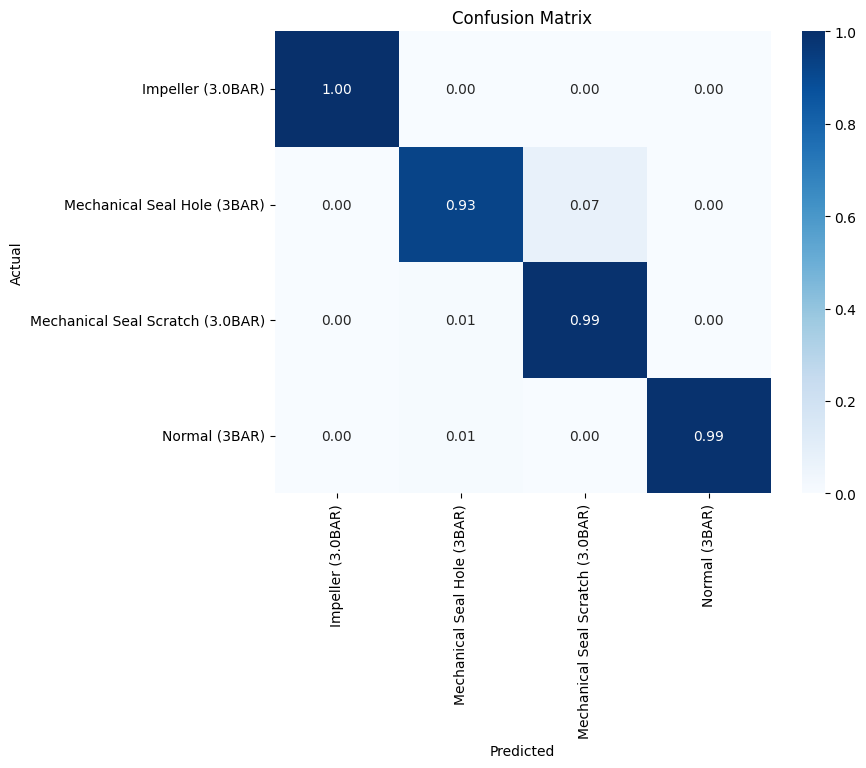

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(model, test_loader, class_names):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Plot Confusion Matrix
plot_confusion_matrix(swa_model, test_loader, class_names)
